# Reinforcement Learning 2025 - Policy Evaluation

**Authors:** Gal Yaacov Noy, Amit Ezer.

**Goal:** Comprehensive evaluation of all trained SARSA and Double Q-Learning policies across different configurations and environments.

This notebook provides a reproducible evaluation procedure that runs each trained policy for 100 episodes and reports detailed performance metrics with visualizations and summary statistics.

In [48]:
import numpy as np
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import minigrid
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import os
from IPython.display import Video, display

np.random.seed(42)

In [ ]:
def get_state(obs):
    """Convert observation to a hashable key."""
    return (obs["direction"], tuple(obs["image"].flatten()))

def greedy_action(q_func, state):
    """Select the action with the highest Q-value for a given state."""
    return int(np.argmax(q_func(state)))

def run_episode(env, q_func, max_steps=200):
    """Run a single episode using the provided Q-function."""
    obs, _ = env.reset()
    state = get_state(obs)
    total_reward, step = 0, 0
    terminated = truncated = False

    while not (terminated or truncated) and step < max_steps:
        action = greedy_action(q_func, state)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        state = get_state(next_obs)
        total_reward += reward
        step += 1

    return total_reward, step, reward > 0

In [44]:
def load_policy(policy_path, env):
    """Load a Q-table policy from pickle file."""
    with open(policy_path, "rb") as f:
        q_dict = pickle.load(f)
    return defaultdict(lambda: np.zeros(env.action_space.n), q_dict)

def evaluate_policy(env, q_func, num_episodes=100, max_steps=200):
    """Evaluate a deterministic policy over multiple episodes."""
    rewards, steps, successes = [], [], []
    
    for episode in range(num_episodes):
        total_reward, step, success = run_episode(env, q_func, max_steps)
        rewards.append(total_reward)
        steps.append(step)
        successes.append(success)
        
        if episode % 20 == 0:
            print(f"  Episode {episode}: Reward={total_reward:.2f}, Steps={step}, Success={success}")

    return {
        "rewards": rewards,
        "steps": steps,
        "successes": successes,
    }

In [52]:
def record_final_video(q_func, env="6x6", model="sarsa"):
    """Record a video of a single greedy policy episode."""
    
    env_name = f"MiniGrid-Dynamic-Obstacles-{env}-v0"
    filename = f"{env}-{model}-final"
    video_dir = "videos"
    
    os.makedirs(video_dir, exist_ok=True)

    env_wrapped = RecordVideo(
        gym.make(env_name, render_mode="rgb_array"),
        video_folder=video_dir,
        name_prefix=filename,
        episode_trigger=lambda _: True
    )

    run_episode(env_wrapped, q_func, max_steps=100)
    env_wrapped.close()
    
    return os.path.join(video_dir, f"{filename}-episode-0.mp4")

In [53]:
def run_evaluation(config_name, env_name, policies_folder):
    """Run evaluation for a configuration and return results with videos."""
    print(f"\n{'='*50}")
    print(f"EVALUATING: {config_name}")
    print(f"{'='*50}")
    
    env = gym.make(env_name)
    env_size = "6x6" if "6x6" in env_name else "8x8"
    results = {}
    
    # Load and evaluate SARSA
    sarsa_q = load_policy(f"policies/{policies_folder}/sarsa_q.pkl", env)
    sarsa_q_func = lambda s: sarsa_q[s]
    print("Evaluating SARSA...")
    results["SARSA"] = evaluate_policy(env, sarsa_q_func)
    results["SARSA"]["video"] = record_final_video(sarsa_q_func, env_size, "sarsa")
    
    # Load and evaluate Double Q-Learning
    dq_q1 = load_policy(f"policies/{policies_folder}/double_q1.pkl", env)
    dq_q2 = load_policy(f"policies/{policies_folder}/double_q2.pkl", env)
    dq_q_func = lambda s: dq_q1[s] + dq_q2[s]
    print("Evaluating Double Q-Learning...")
    results["Double Q-Learning"] = evaluate_policy(env, dq_q_func)
    results["Double Q-Learning"]["video"] = record_final_video(dq_q_func, env_size, "double_q")
    
    env.close()
    return results

In [54]:
# Run evaluations for best 6x6 and 8x8 configurations only
configs = [
    ("6x6", "MiniGrid-Dynamic-Obstacles-6x6-v0", "random_q_init_+_reward_shaping"),
    ("8x8", "MiniGrid-Dynamic-Obstacles-8x8-v0", "8x8_dynamic_obstacles")
]

all_results = {}
for config_name, env_name, folder in configs:
    all_results[config_name] = run_evaluation(config_name, env_name, folder)

# Add summary metrics
for config_name, results in all_results.items():
    for alg_name, metrics in results.items():
        metrics["success_rate"] = np.mean(metrics["successes"])
        metrics["avg_reward"] = np.mean(metrics["rewards"])
        metrics["avg_steps"] = np.mean(metrics["steps"])


EVALUATING: 6x6
Evaluating SARSA...
  Episode 0: Reward=0.77, Steps=37, Success=True
  Episode 20: Reward=0.77, Steps=37, Success=True
  Episode 40: Reward=0.87, Steps=21, Success=True
  Episode 60: Reward=0.58, Steps=67, Success=True
  Episode 80: Reward=0.76, Steps=39, Success=True


/home/galnoy/git-projects/MSC-Reinforcement-Learning/.venv/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /home/galnoy/git-projects/MSC-Reinforcement-Learning/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Evaluating Double Q-Learning...
  Episode 0: Reward=0.74, Steps=42, Success=True
  Episode 20: Reward=0.81, Steps=31, Success=True
  Episode 40: Reward=0.67, Steps=53, Success=True
  Episode 60: Reward=0.63, Steps=59, Success=True
  Episode 80: Reward=0.89, Steps=17, Success=True

EVALUATING: 8x8
Evaluating SARSA...
  Episode 0: Reward=0.61, Steps=112, Success=True
  Episode 20: Reward=0.83, Steps=47, Success=True
  Episode 40: Reward=0.00, Steps=200, Success=False
  Episode 60: Reward=0.80, Steps=56, Success=True
  Episode 80: Reward=0.82, Steps=50, Success=True
Evaluating Double Q-Learning...
  Episode 0: Reward=0.76, Steps=69, Success=True
  Episode 20: Reward=0.00, Steps=200, Success=False
  Episode 40: Reward=0.87, Steps=38, Success=True
  Episode 60: Reward=0.78, Steps=62, Success=True
  Episode 80: Reward=0.75, Steps=71, Success=True


In [55]:
# Results summary and video display
print(f"\n{'='*80}")
print("EVALUATION RESULTS SUMMARY")
print(f"{'='*80}")
print(f"{'Configuration':<15} {'Algorithm':<18} {'Success Rate':<12} {'Avg Reward':<12} {'Avg Steps':<10}")
print("-" * 70)

for config_name, results in all_results.items():
    for alg_name, metrics in results.items():
        success_rate = metrics["success_rate"]
        print(f"{config_name:<15} {alg_name:<18} {success_rate:<12.3f} {metrics['avg_reward']:<12.3f} {metrics['avg_steps']:<10.1f}")

# Display videos
print(f"\n{'='*50}")
print("PERFORMANCE VIDEOS")
print(f"{'='*50}")

for config_name, results in all_results.items():
    print(f"\n{config_name} Results:")
    for alg_name, metrics in results.items():
        print(f"\n{alg_name} - Success Rate: {metrics['success_rate']:.3f}")
        display(Video(metrics["video"], width=400, height=300))


EVALUATION RESULTS SUMMARY
Configuration   Algorithm          Success Rate Avg Reward   Avg Steps 
----------------------------------------------------------------------
6x6             SARSA              0.980        0.729        43.0      
6x6             Double Q-Learning  0.980        0.656        54.7      
8x8             SARSA              0.890        0.576        72.5      
8x8             Double Q-Learning  0.780        0.526        86.6      

PERFORMANCE VIDEOS

6x6 Results:

SARSA - Success Rate: 0.980



Double Q-Learning - Success Rate: 0.980



8x8 Results:

SARSA - Success Rate: 0.890



Double Q-Learning - Success Rate: 0.780



DETAILED PERFORMANCE ANALYSIS

6x6 Results:
SARSA – Success Rate: 0.980, Avg Reward: 0.729, Avg Steps: 43.0
Double Q-Learning – Success Rate: 0.980, Avg Reward: 0.656, Avg Steps: 54.7


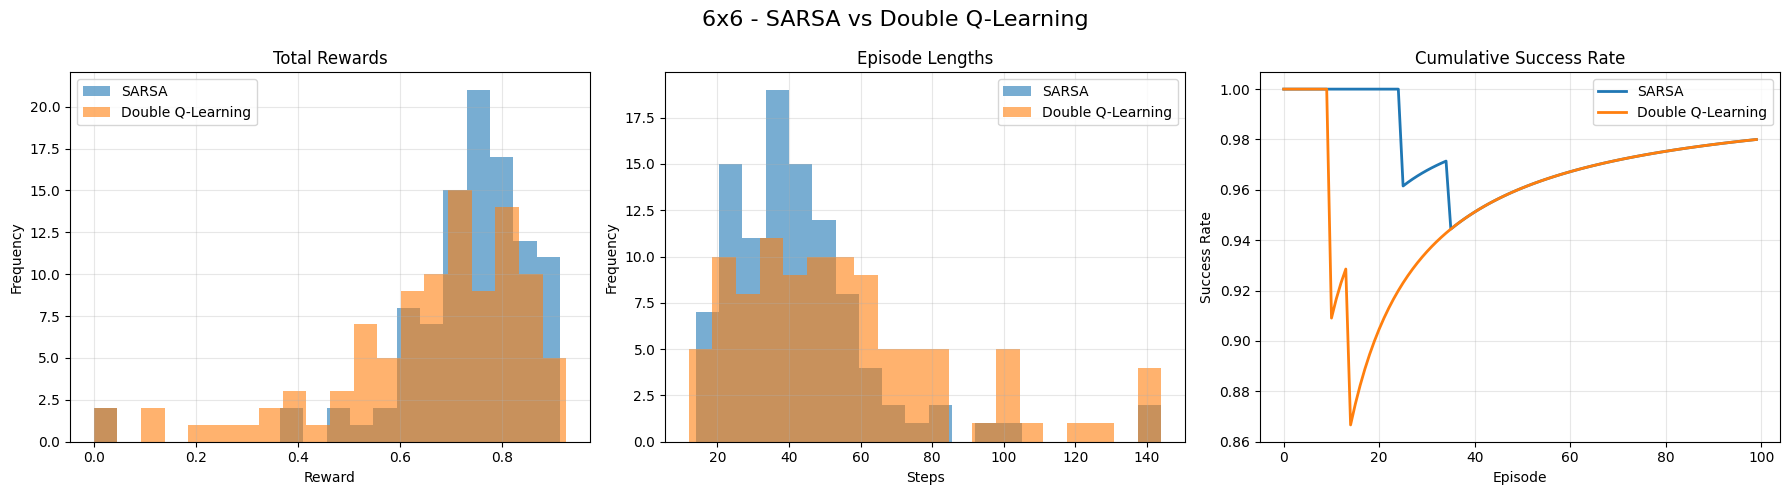


8x8 Results:
SARSA – Success Rate: 0.890, Avg Reward: 0.576, Avg Steps: 72.5
Double Q-Learning – Success Rate: 0.780, Avg Reward: 0.526, Avg Steps: 86.6


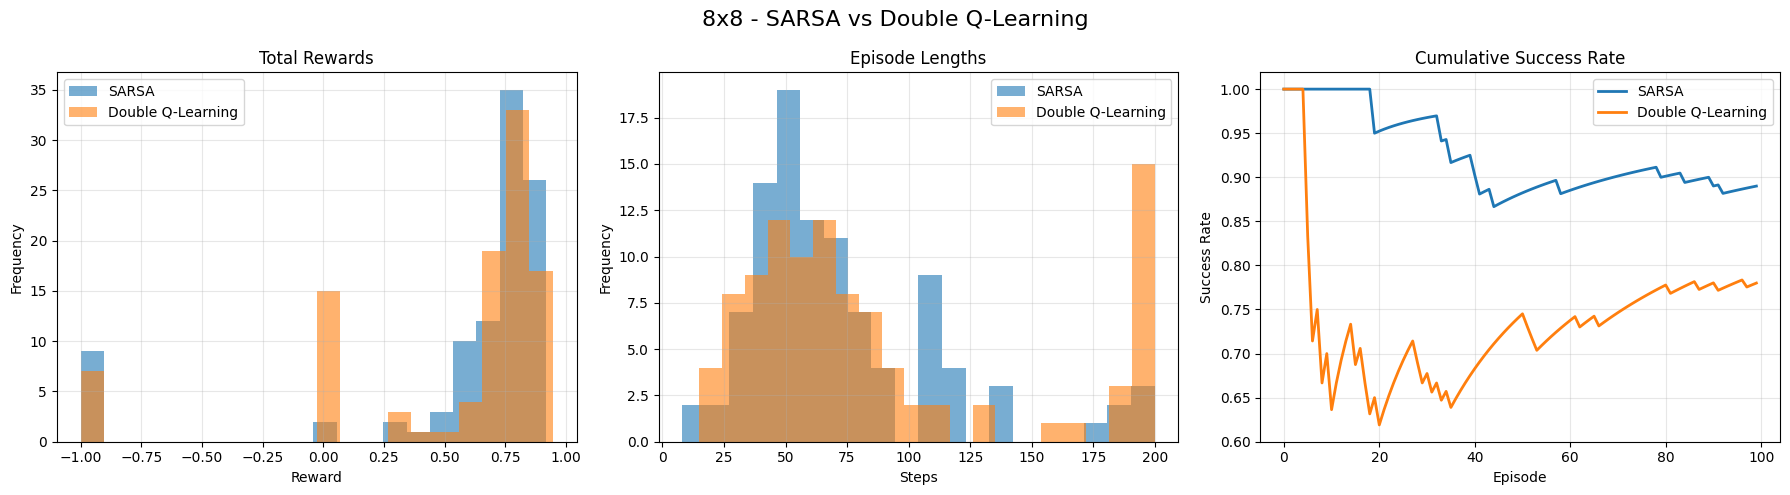


Evaluation complete!


In [56]:
# Comparison plots like evaluation.ipynb
def plot_eval_comparison(results_6x6, results_8x8, title_suffix):
    """Plot comparison between SARSA and Double Q-Learning for a configuration."""
    sarsa_results = results_6x6["SARSA"] if "6x6" in title_suffix else results_8x8["SARSA"]
    dq_results = results_6x6["Double Q-Learning"] if "6x6" in title_suffix else results_8x8["Double Q-Learning"]
    
    print(f"\n{title_suffix} Results:")
    print(f"SARSA – Success Rate: {np.mean(sarsa_results['successes']):.3f}, "
          f"Avg Reward: {np.mean(sarsa_results['rewards']):.3f}, "
          f"Avg Steps: {np.mean(sarsa_results['steps']):.1f}")
    
    print(f"Double Q-Learning – Success Rate: {np.mean(dq_results['successes']):.3f}, "
          f"Avg Reward: {np.mean(dq_results['rewards']):.3f}, "
          f"Avg Steps: {np.mean(dq_results['steps']):.1f}")

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"{title_suffix} - SARSA vs Double Q-Learning", fontsize=16)

    # Histogram of rewards
    axs[0].hist(sarsa_results["rewards"], bins=20, alpha=0.6, label="SARSA")
    axs[0].hist(dq_results["rewards"], bins=20, alpha=0.6, label="Double Q-Learning")
    axs[0].set_title("Total Rewards")
    axs[0].set_xlabel("Reward")
    axs[0].set_ylabel("Frequency")
    axs[0].legend()
    axs[0].grid(alpha=0.3)

    # Histogram of steps
    axs[1].hist(sarsa_results["steps"], bins=20, alpha=0.6, label="SARSA")
    axs[1].hist(dq_results["steps"], bins=20, alpha=0.6, label="Double Q-Learning")
    axs[1].set_title("Episode Lengths")
    axs[1].set_xlabel("Steps")
    axs[1].set_ylabel("Frequency")
    axs[1].legend()
    axs[1].grid(alpha=0.3)

    # Success rate over episodes
    sarsa_sr = np.cumsum(sarsa_results["successes"]) / np.arange(1, len(sarsa_results["successes"]) + 1)
    dq_sr = np.cumsum(dq_results["successes"]) / np.arange(1, len(dq_results["successes"]) + 1)

    axs[2].plot(sarsa_sr, label="SARSA", linewidth=2)
    axs[2].plot(dq_sr, label="Double Q-Learning", linewidth=2)
    axs[2].set_title("Cumulative Success Rate")
    axs[2].set_xlabel("Episode")
    axs[2].set_ylabel("Success Rate")
    axs[2].legend()
    axs[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

print(f"\n{'='*60}")
print("DETAILED PERFORMANCE ANALYSIS")
print(f"{'='*60}")

# Plot comparisons for each environment
plot_eval_comparison(all_results["6x6"], all_results["8x8"], "6x6")
plot_eval_comparison(all_results["6x6"], all_results["8x8"], "8x8")

print("\nEvaluation complete!")